In [15]:
import sf_quant.data as sfd
import polars as pl
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [16]:
priors = pl.read_parquet("../data/priors.parquet")

priors

date,barrid,pi
date,str,f64
1996-12-10,"""USAA191""",0.006586
1996-12-10,"""USAA1Y1""",0.013124
1996-12-10,"""USAA251""",0.008993
1996-12-10,"""USAA311""",0.005526
1996-12-10,"""USAA3I1""",0.005232
…,…,…
2000-11-02,"""USAZXG1""",0.000441
2000-11-02,"""USAZXI1""",0.000352
2000-11-02,"""USAZXN1""",0.000513


In [ ]:
start = dt.date(1995, 6, 30)
end = dt.date(2024, 12, 31)

benchmark = sfd.load_benchmark(
    start=start,
    end=end,
)

benchmark

date,barrid,weight
date,str,f64
2013-07-31,"""USA06Z1""",0.00003
2013-08-01,"""USA06Z1""",0.00003
2013-08-02,"""USA06Z1""",0.00003
2013-08-05,"""USA06Z1""",0.000031
2013-08-06,"""USA06Z1""",0.00003
…,…,…
2024-12-24,"""USBQOR1""",0.000058
2024-12-26,"""USBQOR1""",0.000061
2024-12-27,"""USBQOR1""",0.000058


In [18]:
columns = ["date", "barrid", "fwd_return"]
returns = sfd.load_assets(start=start, end=end, in_universe=True, columns=columns)

returns

date,barrid,fwd_return
date,str,f64
2013-07-31,"""USA06Z1""",0.9585
2013-08-01,"""USA06Z1""",-0.1582
2013-08-02,"""USA06Z1""",2.2187
2013-08-05,"""USA06Z1""",-2.4806
2013-08-06,"""USA06Z1""",-8.1081
…,…,…
2024-12-24,"""USBQOR1""",4.293
2024-12-26,"""USBQOR1""",-5.108
2024-12-27,"""USBQOR1""",-4.2663


In [19]:
benchmark_returns = (
    benchmark.join(returns, on=["date", "barrid"], how="left")
    .with_columns(
        (pl.col("fwd_return") / 100)
    )
    .group_by("date")
    .agg(
        (pl.col("fwd_return") * pl.col("weight")).sum().alias("benchmark_return")
    )
    .sort("date")
)

In [20]:
benchmark_returns

date,benchmark_return
date,f64
1995-06-30,0.00363
1995-07-03,0.001927
1995-07-05,0.011535
1995-07-06,0.006099
1995-07-07,0.001636
…,…
2024-12-24,0.000289
2024-12-26,-0.011463
2024-12-27,-0.010511


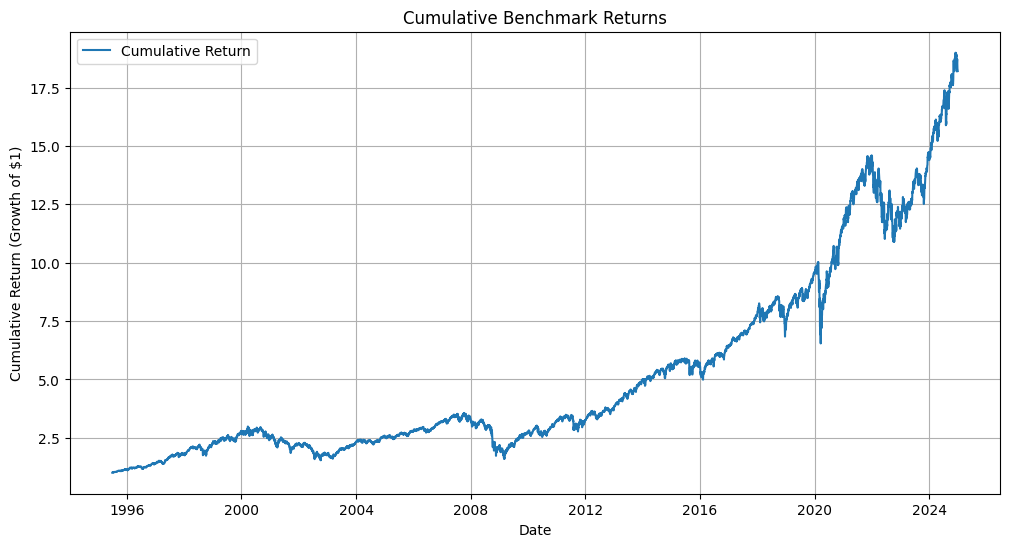

In [21]:
# Calculate cumulative returns
benchmark_returns_1 = benchmark_returns.with_columns(
    (1 + pl.col("benchmark_return")).cum_prod().alias("cumulative_return")
)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(benchmark_returns_1["date"], benchmark_returns_1["cumulative_return"], label="Cumulative Return")
plt.title("Cumulative Benchmark Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Step 1: join priors with benchmark weights
priors_with_w = priors.join(
    benchmark.select(["date", "barrid", "weight"]),
    on=["date", "barrid"],
    how="inner"
)

# Step 2: weighted sum of pi for each date
prior_returns = (
    priors_with_w
    .with_columns((pl.col("pi") * pl.col("weight")).alias("weighted_pi"))
    .group_by("date")
    .agg(pl.col("weighted_pi").sum().alias("prior_return"))
)

# Step 3: join with benchmark return
comparison = prior_returns.join(
    benchmark_returns.select(["date", "benchmark_return"]),
    on="date",
    how="inner"
)

# Step 4: compute difference
comparison = comparison.with_columns(
    (pl.col("prior_return") - pl.col("benchmark_return")).alias("diff")
)

comparison


date,prior_return,benchmark_return,diff
date,f64,f64,f64
1995-10-03,0.004632,-0.003904,0.008536
1995-10-04,0.004597,0.003045,0.001552
1995-10-05,0.004473,0.000023,0.00445
1995-10-06,0.003147,-0.009921,0.013067
1995-10-09,0.002708,-0.00212,0.004828
…,…,…,…
2024-12-24,0.003588,0.000289,0.003299
2024-12-26,0.002694,-0.011463,0.014157
2024-12-27,0.002221,-0.010511,0.012732


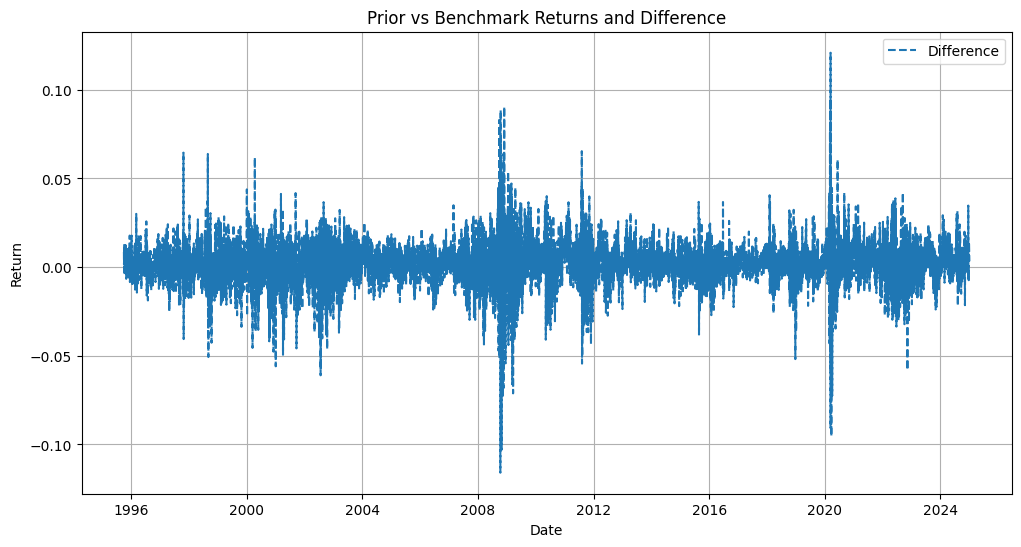

In [23]:
comp_pd = comparison.to_pandas()

# Plot prior_return and benchmark_return
plt.figure(figsize=(12, 6))

# Plot the difference on secondary axis
plt.plot(comp_pd["date"], comp_pd["diff"], label="Difference", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Prior vs Benchmark Returns and Difference")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
average_diff = comp_pd["diff"].mean()

average_diff

np.float64(0.0019493359580370843)